In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from scipy.optimize import curve_fit
import estimation_functions as ef
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [199]:
#set data folder path, this is on the same level of the current folder
data_folder = '../Data/'
result_folder = '../Figures/'
df_import = pd.read_csv(data_folder + '/simulated_data.csv')
# remove the first 100 data points to ignore initial conditions
df_import = df_import[100:]

In [200]:
# Create the estimation data set
def create_estimation_df(df, a = 1.0):
    df_estimation = pd.DataFrame()
    #Divide each variable by 10000 to make the coefficients of the same order of magnitude
    df_estimation['y'] = df['data']
    df_estimation['x0'] = df['data'].shift(1)
    df_estimation['x1'] = df['data'].shift(2)
    df_estimation['x2'] = df['data'].shift(3)
    df_estimation['y_ML'] =df['data'].shift(-1)
    df_estimation = df_estimation.dropna()
    return df_estimation

df_estimation = create_estimation_df(df_import)

In [201]:
#Define the data for the LSTM
X = df_estimation[['x0','x1','x2']].values
#sum X across the columns
y = df_estimation['y_ML'].values

# Reshape the input data to be 3D (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [202]:
# Define a deep neural network
model = Sequential()

# add a dense layer with 100 neurons
model.add(LSTM(96, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# set learning rate
model.optimizer.lr = 0.01

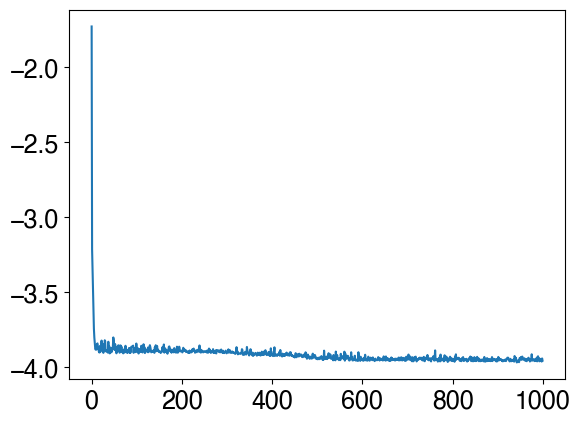

In [203]:
# Train the model
model.fit(X, y, epochs=1000, verbose=0)

# show the loss of the model
plt.plot(np.log(model.history.history['loss']), label='train')

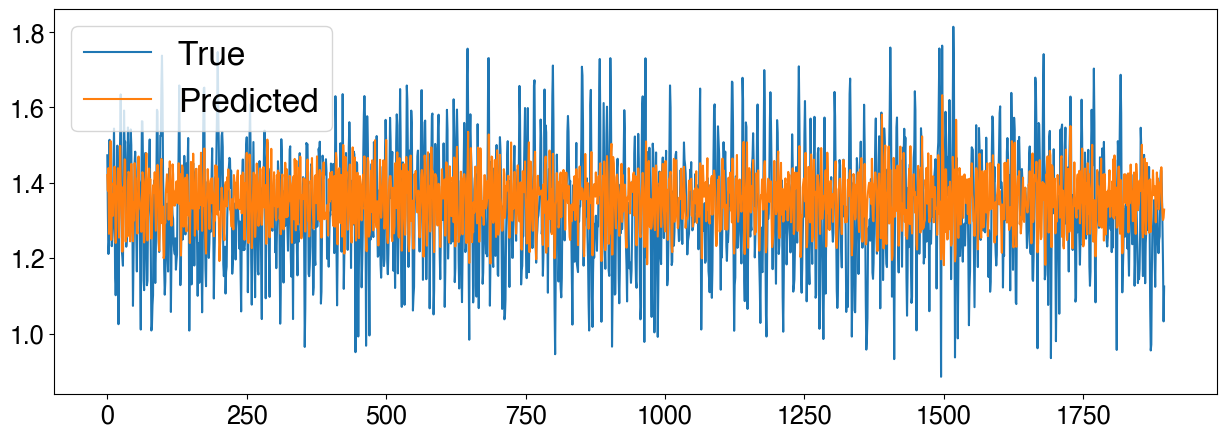

In [204]:
#Make predictions
yhat = model.predict(X, verbose=0)[:,-1] #go from 3d to 2d 

# Plot the results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y, label='True')
ax.plot(yhat,  label='Predicted')
ax.legend()
plt.show()
fig.savefig(result_folder + 'LSTM_prediction.png')

In [205]:
# Evaluate the r-squared
tss = np.sum((y - np.mean(y))**2)
rss = np.sum((y - yhat)**2)
r_squared = 1 - rss/tss
print(r_squared)

0.16143367850846646


In [206]:
#add the predictions to the estimation data
df_estimation['x3'] = yhat
#  # shift by 2 yhat
df_estimation['x4'] = np.roll(yhat, 2)
df_estimation['x5'] = 1.01 #R

In [207]:
def trend_follower_plus_bias_plus_LSTM_simulated(x, g, b, beta):
    #y = x(t), x0 = x(t-1), x1 = x(t-2), x2 = x(t-3)
    # x3 =  LSTM(t+1), x4 = LSTM(t-2), x5 = R
    # g = params[0]
    # b = params[1]
    # beta = params[2]
    #Chatch the overflow error
    fitness_1 = (x[0] - x[5]*x[1]) * (g * x[2] - x[5]*x[1])
    fitness_2 = (x[0] - x[5]*x[1]) * (b - x[5]*x[1])
    fitness_3 = (x[0] - x[5]*x[1]) * (x[4] - x[5]*x[1])
    n1 = np.exp(beta * (fitness_1))/(np.exp(beta * (fitness_1)) + np.exp(beta * (fitness_2)) + np.exp(beta * (fitness_3)))
    n2 = np.exp(beta * (fitness_2))/(np.exp(beta * (fitness_1)) + np.exp(beta * (fitness_2)) + np.exp(beta * (fitness_3)))
    n3 = np.exp(beta * (fitness_3))/(np.exp(beta * (fitness_1)) + np.exp(beta * (fitness_2)) + np.exp(beta * (fitness_3)))
    return  (g* x[0] * n1 + b * (n2) + x[3]*n3)/x[5]


In [208]:
#Define x_data and y_da
df = df_estimation
x_data = [df['x0'], df['x1'], df['x2'], df['x3'], df['x4'], df['x5']]
y_data = df['y']
# Estimate the parameters
popt_1, pcov_1 = ef.estimate_params(trend_follower_plus_bias_plus_LSTM_simulated, x_data, y_data)

In [209]:
print(popt_1, np.sqrt(np.diagonal(pcov_1)))

[1.25114266 1.03707329 6.75235441] [0.017777   0.02322778 1.14075049]
